## Introduzione
L'obiettivo stabilito per questo argomento è quello di condurre un esperimento di ***apprendimento supervisionato*** per la **classificazione** dei segmenti stradali in base al **livello di pericolosità**. In primis è stata costruita la feature relativa alla pericolosità, che non era presente nel dataset originale. Tale variabile è stata costruita combinando diverse informazioni disponibili, come il numero di incidenti, il numero di feriti e di morti, la lunghezza dei segmenti stradali e i limiti di velocità di quest'ultimi, al fine di definire un indicatore significativo per la classificazione.

## Librerie utilizzate

In [ ]:
import networkx as nx # utile per la creazione e manipolazione di grafi complessi.
import osmnx as ox # utile per scaricare, modellare, analizzare e visualizzare facilmente reti stradali e altre funzionalità geospaziali da OpenStreetMap
import pandas as pd # utile per la manipolazione e l'analisi dei dati
import numpy as np # utile per la manipolazione di array e matrici
import matplotlib.pyplot as plt # utile per la creazione di grafici
import seaborn as sns # utile per la creazione di grafici
from sklearn.preprocessing import StandardScaler # utile per la standardizzazione dei dati
from sklearn.model_selection import StratifiedKFold # utile per la creazione di fold per la cross validation
from sklearn.ensemble import RandomForestClassifier # modello di classificazione random forest
from xgboost import XGBClassifier # modello di classificazione xgboost
from lightgbm import LGBMClassifier # modello di classificazione lightgbm
from catboost import CatBoostClassifier # modello di classificazione catboost
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix # metriche di valutazione

# Rappresentazione della conoscenza per KB
La base di conoscenza da cui si è partiti per condurre l'esperimento era rappresentata da un dataset (DataSet_Puglia.csv), contenente i segmenti stradali della regione Puglia con diverse informazioni associate, tra le quali:  

- **ID_Segmento**: codice identificativo di un segmento stradale
- **ANNO**: arco temporale di considerazione per quel segmento
- **NUM_INCIDENTI**: numero di incidenti avvenuti sul quel segmento
- **MORTI**: numero di decessi avvenuti su quel segmento
- **FERITI**: numero di feriti su quel segmento
- **LOCINC**: tipologia di strada (urbana, exstraurbana ecc..)
- **INTNIN**: indica se il segmento è un intersezione o no (rettilineo, incrocio ecc..)
- **FONDOST**: tipologia di fondo stradale (asciutto, bagnato ecc..)
- **LUNGHEZZA**: lunghezza del segmento in metri  

**N.B:** informazioni specifiche per questi valori sono contenute nel file "Microdati.xlsx" presente nella directory \\Dati della repository.  

Come è stato introdotto nel paragrafo precedente, al fine dell'esperimento era necessario costruire una features che rappresentasse la **pericolosità di un segmento**. Per fare ciò, il team ha deciso di aggiugnere l'informazione circa la massima velocità consentita sul segmento stradale (MAXSPEED), prelevandola dal grafo rappresentante la rete stradale della puglia grazie al seguente script:  

In [ ]:
# Salvataggio la rete stradale della Puglia in un file .graphml
G = ox.graph_from_place('Puglia, Italy', network_type='drive')
G = ox.save_graphml(G,'rete_puglia.graphml')

# Percorsi ai file
pathGraph = '..\\Dati\\rete_puglia.graphml'
pathData = '..\\Dati\\Dati_segmenti_stradali.csv'

# Carica il grafo e il dataset
G = ox.load_graphml(pathGraph)
data = pd.read_csv(pathData)

# Dizionario per associare osmid a maxspeed
osmid_to_maxspeed = {}

for u, v, edge_data in G.edges(data=True):
    osmid = edge_data.get('osmid')
    maxspeed = edge_data.get('maxspeed', None)

    if isinstance(osmid, list):  # Se osmid è una lista, prendiamo il primo valore
        osmid = osmid[0]

    if osmid is not None:
        osmid_to_maxspeed[osmid] = maxspeed  # Associa osmid a maxspeed

# Aggiungi maxspeed al dataset basandoti su ID_Segmento
data['maxspeed'] = data['ID_Segmento'].map(osmid_to_maxspeed)

# Salva il dataset aggiornato
data.to_csv("DataSet_Puglia.csv", index=False)

Per diversi segmenti non è stato possibile assegnare un valore a MAXSPEED, in quanto tale informazione non era presente all'interno del grafo G.  
Per evitare la presenza di valori nulli, è stato adottato un metodo di assegnazione basato sulla **tipologia di strada**, identificata attraverso la feature **LOCINC**. Grazie a una ricerca sul web, è stato possibile stabilire che, nella maggior parte dei casi, il limite di velocità per le *strade urbane è di 50 km/h*, per le *strade extraurbane è di 90 km/h*, mentre per le *autostrade* il limite è di *130 km/h*. 

In [ ]:
"""Script utile ad assegare la velocità massima consentita 
in base alla features LOCINC del segmento stradale"""

data = pd.read_csv('DataSet_Puglia.csv')

def set_maxspeed(locinc):
    if locinc in [0, 1, 2, 3]:
        return 50
    elif locinc in [4, 5, 6, 8]:
        return 90
    elif locinc == 7:
        return 130
    else:
        return None
    
data['MAXSPEED'] = data['LOCINC'].apply(set_maxspeed).astype("Int64")

data.to_csv('DataSet_Puglia.csv', index=False)

## Assegnazione dell'Indice di Pericolosità

#### **Aggregazione dei Dati**
Per garantire una valutazione coerente della pericolosità dei segmenti stradali, abbiamo aggregato i dati relativi ai segmenti che si presentavano più volte nel dataset in anni diversi. L'aggregazione è stata effettuata seguendo i seguenti criteri:

- **Sommatoria** del numero di incidenti, morti e feriti per ogni segmento.
- **Media** del limite di velocità (*MAXSPEED*).
- **Valore più frequente** per le variabili categoriali (*LOCINC*, *INTNIN*, *FONDOST*).
- **Lunghezza del segmento** mantenuta invariata.

#### **Calcolo dell'Indice di Pericolosità**
Dopo aver aggregato i dati, è stato definito un **Indice di Pericolosità** per ogni segmento stradale, basato sulla seguente formula:

$$
Indice\_Pericolosita = \frac{(NUM\_INCIDENTI + 3 \cdot MORTI + 0.5 \cdot FERITI)}{LUNGHEZZA \cdot \left(\frac{MAXSPEED}{50}\right)}
$$

##### **Interpretazione della Formula:**

- $NUM\_INCIDENTI$: rappresenta il numero totale di incidenti registrati su un determinato segmento.
- $MORTI$: ha un peso maggiore (moltiplicato per 3) per enfatizzare la gravità delle conseguenze fatali.
- $FERITI$: ha un peso ridotto (moltiplicato per 0.5) rispetto ai morti, in quanto meno impattante.
- $LUNGHEZZA$: del segmento è inclusa nel denominatore per normalizzare il valore in base alla dimensione della strada.
- $MAXSPEED$: è normalizzato rispetto al valore di 50 km/h per mantenere coerenza con i limiti di velocità tipici.

#### **Classificazione del Rischio**  

Per assegnare una classe di pericolosità ai segmenti stradali, abbiamo utilizzato i **quantili della distribuzione** dell'indice:  

- $Q_1$ *(25° percentile)*: rappresenta il valore sotto il quale si trovano il 25% dei dati.
- $Q_2$ *(mediana, 50° percentile)*: divide la distribuzione a metà.
- $Q_3$ *(75° percentile)*: rappresenta il valore sopra il quale si trovano il 25% dei dati.  

La classificazione è stata effettuata come segue:

$$
Classe\_Pericolosita =
\begin{cases}
1, & \text{se } Indice\_Pericolosita \leq Q_2 \\
2, & \text{se } Q_2 < Indice\_Pericolosita \leq Q_3 \\
3, & \text{se } Indice\_Pericolosita > Q_3
\end{cases}
$$

##### **Descrizione delle Classi:**
- **Classe 1:** Segmenti **poco pericolosi** (sotto la mediana della distribuzione).
- **Classe 2:** Segmenti **mediamente pericolosi** (tra la mediana e il 75° percentile).
- **Classe 3:** Segmenti **molto pericolosi** (sopra il 75° percentile, quindi nei valori più elevati dell'indice).

Il dataset finale risultante da questa fase è stato salvato come **"DataSet_Puglia_Aggregato.csv"**, pronto per le fasi successive di analisi e modellazione.



In [6]:


# Caricare il dataset
file_path = "DataSet_Puglia.csv"  # Modifica il percorso se necessario
df = pd.read_csv(file_path, sep=",", encoding="utf-8")

# Aggregazione per ID_Segmento
df_agg = df.groupby("ID_Segmento").agg({
    "NUM_INCIDENTI": "sum",  # Sommare gli incidenti di tutti gli anni
    "MORTI": "sum",          # Sommare i morti
    "FERITI": "sum",         # Sommare i feriti
    "LUNGHEZZA": "first",    # La lunghezza rimane invariata per segmento
    "MAXSPEED": "mean",      # Possiamo prendere la media o il valore più frequente
    "LOCINC": lambda x: x.mode()[0],  # Prendere il valore più frequente
    "INTNIN": lambda x: x.mode()[0],  # Prendere il valore più frequente
    "FONDOST": lambda x: x.mode()[0]  # Prendere il valore più frequente
}).reset_index()

# Calcolo indice di pericolosità
df_agg["Indice_Pericolosita"] = (df_agg["NUM_INCIDENTI"] + 3 * df_agg["MORTI"] + 0.5 * df_agg["FERITI"]) / (df_agg["LUNGHEZZA"] * (df_agg["MAXSPEED"] / 50))

# Calcolo dei quantili per la classificazione
q1 = df_agg["Indice_Pericolosita"].quantile(0.25)  # 25° percentile
q2 = df_agg["Indice_Pericolosita"].median()        # 50° percentile (mediana)
q3 = df_agg["Indice_Pericolosita"].quantile(0.75)  # 75° percentile

# Funzione per assegnare il livello numerico di pericolosità
def classify_risk(index):
    if index <= q2:
        return 1  # Poco Pericoloso
    elif q2 < index <= q3:
        return 2  # Mediamente Pericoloso
    else:
        return 3  # Molto Pericoloso

# Applicare la classificazione numerica
df_agg["PERICOLOSITA"] = df_agg["Indice_Pericolosita"].apply(classify_risk)

#drop colonna valore pericolosità
df_agg = df_agg.drop(columns=["Indice_Pericolosita"])

# Salvare il dataset aggiornato con i dati aggregati
df_agg.to_csv("DataSet_Puglia_Aggregato.csv", index=False)

# Stampare la distribuzione delle classi numeriche
print(df_agg["PERICOLOSITA"].value_counts())


PERICOLOSITA
1    10159
3     5080
2     5079
Name: count, dtype: int64


## **Bilanciamento del Dataset**
Dall'analisi della distribuzione delle classi di pericolosità, è emerso che la **Classe 1** presentava un numero significativamente maggiore di istanze rispetto alle altre due classi:

$$
1 = 10159, \quad 3 = 5080, \quad 2 = 5079
$$

Poiché un dataset sbilanciato può compromettere l'efficacia del modello, si è deciso di applicare una tecnica di **undersampling** per ridurre il numero di istanze appartenenti alla **Classe 1**, in modo da ottenere un dataset bilanciato. 

L'undersampling è stato eseguito eliminando in modo casuale un sottoinsieme di esempi della classe dominante, mantenendo comunque una rappresentazione statisticamente valida dei dati.

Questa operazione ha permesso di:  

- Evitare che il modello imparasse un **pregiudizio verso la classe più frequente**.
- Garantire una distribuzione più equa delle classi, migliorando la capacità del modello di generalizzare le predizioni.  

Il dataset bilanciato risultante è stato salvato come **"DataSet_Puglia_Bilanciato.csv"** ed è stato utilizzato nelle fasi successive di addestramento e valutazione del modello.

In [32]:
"""Bilanciamento del dataset"""

# Caricare il dataset aggregato
file_path = "DataSet_Puglia_Aggregato.csv"  # Modifica il percorso se necessario
df_agg = pd.read_csv(file_path, sep=",", encoding="utf-8")

# Suddividere il dataset in base alle classi
df_class_1 = df_agg[df_agg["PERICOLOSITA"] == 1]
df_class_2 = df_agg[df_agg["PERICOLOSITA"] == 2]
df_class_3 = df_agg[df_agg["PERICOLOSITA"] == 3]

# Effettuare l'undersampling della Classe 1 (ridurla a 5.080 entry per bilanciare)
df_class_1_under = df_class_1.sample(n=5080, random_state=42)

# Ricombinare il dataset bilanciato
df_balanced = pd.concat([df_class_1_under, df_class_2, df_class_3])

# Salvare il dataset bilanciato
df_balanced.to_csv("DataSet_Puglia_Bilanciato.csv", index=False)

# Stampare la nuova distribuzione delle classi
print(df_balanced["PERICOLOSITA"].value_counts())


PERICOLOSITA
1    5080
3    5080
2    5079
Name: count, dtype: int64


## **Normalizzazione delle Variabili Numeriche**  
Per migliorare le prestazioni del modello e garantire una corretta comparazione tra le variabili numeriche, è stata applicata la **standardizzazione** alle feature numeriche del dataset, in particolare alle seguenti variabili:  

- **LUNGHEZZA**: rappresenta la lunghezza del segmento stradale.
- **MAXSPEED**: indica il limite di velocità del segmento.

La normalizzazione è stata effettuata utilizzando lo **StandardScaler**, che trasforma i valori in modo che abbiano una **media pari a 0** e una **deviazione standard pari a 1**. Questa operazione garantisce che le variabili siano su scala comparabile, evitando che alcune feature abbiano un peso maggiore rispetto ad altre nel processo di apprendimento del modello.  

La normalizzazione è stata applicata **solo alle variabili numeriche continue** per le seguenti ragioni:  

- **LUNGHEZZA e MAXSPEED sono variabili continue con scale diverse** e senza normalizzazione il modello potrebbe dare più peso alla lunghezza della strada solo per via dell'ordine di grandezza dei valori.
- **Le variabili categoriche (LOCINC, INTNIN, FONDOST) non sono state normalizzate**, poiché rappresentano categorie discrete e non valori numerici continui. Normalizzarle non avrebbe senso, poiché la distanza tra le categorie non ha un significato numerico diretto.  

Il dataset normalizzato è stato infine salvato con il nome **"DataSet_Puglia_Normalizzato.csv"**, pronto per essere utilizzato nelle successive fasi di analisi e modellazione.  

In [ ]:
# Caricare il dataset bilanciato
file_path = "DataSet_Puglia_Bilanciato.csv"
df = pd.read_csv(file_path, sep=",", encoding="utf-8")

# Selezioniamo le feature da normalizzare
numerical_features = ["LUNGHEZZA", "MAXSPEED"]

# Applichiamo la standardizzazione
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Salvare il dataset normalizzato
df.to_csv("DataSet_Puglia_Normalizzato.csv", index=False)

print("Dataset normalizzato e salvato con successo!")


# Classificazione Pericolisità

#### **Classificatori Utilizzati**  

Abbiamo testato diversi modelli di classificazione per identificare il miglior approccio alla previsione della pericolosità stradale:  

- **Random Forest**: Un ensemble di alberi di decisione che riduce l'overfitting e fornisce una buona interpretabilità.
- **XGBoost**: Un potente algoritmo basato su gradient boosting, noto per le alte prestazioni su dati strutturati.
- **LightGBM**: Una variante ottimizzata del boosting che riduce i tempi di addestramento senza sacrificare l'accuratezza.
- **CatBoost**: Un altro algoritmo di boosting particolarmente efficiente nel gestire feature categoriche.

Questi modelli sono stati selezionati in quanto rappresentano i principali metodi di classificazione ad alte prestazioni nel machine learning, in grado di gestire dataset   strutturati e variabili miste (numeriche e categoriche).  

#### **Parametri Utilizzati**  
Per ogni modello, sono stati scelti parametri standard ottimizzati per un buon compromesso tra accuratezza e tempo di addestramento:  

- **n_estimators=100**: Numero di alberi nella foresta per garantire stabilità nelle previsioni.
- **random_state=42**: Garantisce riproducibilità degli esperimenti.
- **eval_metric="mlogloss"** (per XGBoost): Ottimizza la probabilità logaritmica per problemi multi-classe.
- **verbose=0** (per CatBoost): Disabilita output eccessivo durante l'addestramento.

#### **Valutazione dei Modelli**  
La valutazione è stata effettuata con **Stratified K-Fold Cross Validation** (k=5), che garantisce che ogni fold mantenga la distribuzione delle classi, evitando squilibri.  

##### **Metriche di Performance**  
Le seguenti metriche sono state utilizzate per misurare l'efficacia dei modelli:  

- **Accuracy**: Percentuale di previsioni corrette rispetto al totale.
- **F1-Score (micro)**: Media armonica tra precision e recall, utile per dataset bilanciati.
- **Precision**: Proporzione di istanze classificate correttamente tra quelle previste in una classe.
- **Recall**: Percentuale di istanze correttamente classificate rispetto al totale delle istanze di quella classe.  

##### **Strumenti di Visualizzazione**  

- **Matrice di Confusione**: Mostra gli errori di classificazione tra le classi.
- **Confronto delle Accuracy tra i Modelli**: Un grafico a barre per evidenziare le differenze di prestazioni.
- **Curva di apprendimento**: utilizzata per analizzare le prestazioni di un modello in funzione della quantità di dati di training.  

  - **Asse X**: Numero di esempi nel training set.
  - **Asse Y**: Errore del modello (1 - Accuratezza).
  - **Linea Blu (Test Error)**: Errore del modello sui dati di test (valutazione della generalizzazione).
  - **Linea Arancione (Train Error)**: Errore del modello sui dati di training (capacità di apprendimento).

Il file con i risultati dettagliati delle metriche per ogni modello è stato salvato in formato `.xlsx` per un'analisi più approfondita.  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

class ModelEvaluator:
    def __init__(self, file_path, target_column="PERICOLOSITA", n_splits=5, random_state=42):
        self.file_path = file_path
        self.target_column = target_column
        self.n_splits = n_splits
        self.random_state = random_state
        self.models = {
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=random_state),
            "XGBoost": XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="mlogloss"),
            "LightGBM": LGBMClassifier(n_estimators=100, random_state=random_state),
            "CatBoost": CatBoostClassifier(n_estimators=100, verbose=0, random_state=random_state)
        }
        self.results = []
        self.conf_matrices = {}

    def load_data(self):
        df = pd.read_csv(self.file_path, sep=",", encoding="utf-8")
        X = df.drop(columns=[self.target_column])
        y = df[self.target_column] - 1  # Rende le classi [0,1,2] invece di [1,2,3]
        return X, y

    def evaluate_models(self):
        X, y = self.load_data()
        kfold = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

        for model_name, model in self.models.items():
            fold_accuracies = []
            fold_f1_scores = []
            fold_precisions = []
            fold_recalls = []

            for train_index, test_index in kfold.split(X, y):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                fold_accuracies.append(accuracy_score(y_test, y_pred))
                fold_f1_scores.append(f1_score(y_test, y_pred, average="micro"))
                fold_precisions.append(precision_score(y_test, y_pred, average="micro"))
                fold_recalls.append(recall_score(y_test, y_pred, average="micro"))

            self.results.append({
                "Modello": model_name,
                "Accuracy Media": np.mean(fold_accuracies),
                "F1-Score Medio": np.mean(fold_f1_scores),
                "Precision Media": np.mean(fold_precisions),
                "Recall Media": np.mean(fold_recalls),
                "Deviazione Standard": np.std(fold_accuracies),
                "Singole Accuracy": fold_accuracies
            })

            model.fit(X, y)
            y_pred = model.predict(X)
            self.conf_matrices[model_name] = confusion_matrix(y, y_pred)

    def plot_learning_curves(self):
        X, y = self.load_data()
        
        for model_name, model in self.models.items():
            plt.figure(figsize=(8, 6))
            train_sizes, train_scores, test_scores = learning_curve(
                model, X, y, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10), random_state=self.random_state
            )
            
            train_errors = 1 - np.mean(train_scores, axis=1)
            test_errors = 1 - np.mean(test_scores, axis=1)
            
            plt.plot(train_sizes, train_errors, label=f"Train Error", linestyle="--")
            plt.plot(train_sizes, test_errors, label=f"Test Error")
            
            plt.xlabel("Training Size")
            plt.ylabel("Error (1 - Accuracy)")
            plt.title(f"Learning Curve - {model_name}")
            plt.legend()
            plt.grid()
            plt.tight_layout()
            plt.show()

    def save_results(self, excel_path="Risultati_Modelli.xlsx"):
        df_results = pd.DataFrame(self.results)
        df_results.to_excel(excel_path, index=False)
        print("✅ Risultati salvati in:", excel_path)
        print(df_results)

    def plot_conf_matrices(self):
        for model_name, cm in self.conf_matrices.items():
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title(f"Matrice di Confusione - {model_name}")
            plt.xlabel("Predetto")
            plt.ylabel("Reale")
            plt.tight_layout()
            plt.show()

    def plot_model_accuracies(self):
        df_results = pd.DataFrame(self.results)
        plt.figure(figsize=(10, 5))
        sns.barplot(x=df_results["Modello"], y=df_results["Accuracy Media"], palette="viridis")
        plt.title("Confronto delle Accuracy dei Modelli")
        plt.xlabel("Modello")
        plt.ylabel("Accuracy Media")
        plt.ylim(0, 1)
        plt.show()

    def print_fold_accuracies(self):
        for result in self.results:
            print(f"Modello: {result['Modello']}")
            print(f"Singole Accuracy: {result['Singole Accuracy']}")
            print("-")

# Esempio di utilizzo
if __name__ == "__main__":
    
    # evaluator1 = ModelEvaluator(file_path="DataSet_Puglia_Normalizzato.csv")
    # evaluator1.evaluate_models()
    # evaluator1.save_results("Risultati_Modelli_dsn.xlsx")
    # evaluator1.plot_conf_matrices()
    # evaluator1.plot_model_accuracies()
    # evaluator1.print_fold_accuracies()


    evaluator2 = ModelEvaluator(file_path="Notebooks\\DataSet_Puglia_Augmented.csv")
    evaluator2.evaluate_models()
    evaluator2.save_results("Risultati_Modelli_dpaf2.xlsx")
    evaluator2.plot_conf_matrices()
    evaluator2.plot_model_accuracies()
    evaluator2.plot_learning_curves()
    evaluator2.print_fold_accuracies()

## Valutazione dei Risultati dei Modelli

#### **Risultati**

| Modello         | Accuracy Media | F1-Score Medio | Precision Media | Recall Media | Deviazione Standard | Singole Accuracy                                       |
|-----------------|----------------|----------------|-----------------|--------------|---------------------|-------------------------------------------------------|
| Random Forest   | 0.98           | 0.98           | 0.98            | 0.98         | 0.00                | [0.9806, 0.9839, 0.9846, 0.9865, 0.9829]             |
| XGBoost         | 0.99           | 0.99           | 0.99            | 0.99         | 0.00                | [0.9849, 0.9875, 0.9869, 0.9888, 0.9885]             |
| LightGBM        | 0.99           | 0.99           | 0.99            | 0.99         | 0.00                | [0.9882, 0.9859, 0.9879, 0.9879, 0.9902]             |
| CatBoost        | 0.99           | 0.99           | 0.99            | 0.99         | 0.00                | [0.9856, 0.9865, 0.9888, 0.9892, 0.9869]             |  

<br>


![MC_RanFor_dsn](..\Doc\Immagini\Matrice_Confusione_Random_Forest_dsn.png)  

<br>


![MC_XGBoost](..\Doc\Immagini\Matrice_Confusione_XGBoost_dsn.png)  

<br>


![MC_LightGBM](..\Doc\Immagini\Matrice_Confusione_LightGBM_dsn.png)  

<br>


![MC_CatBoost](..\Doc\Immagini\Matrice_Confusione_CatBoost_dsn.png)  



#### **Analisi**  
Osservando i risultati ottenuti per i quattro modelli di classificazione (**Random Forest, XGBoost, LightGBM, CatBoost**), possiamo evidenziare alcune considerazioni importanti:

1. **Accuratezza e Metriche**:
   - Tutti i modelli mostrano **accuracy**, **precision**, **recall**, e **F1-score** molto elevate, vicine al 98%-99%.
   - Le deviazioni standard delle accuracy tra i fold di cross-validation sono praticamente nulle, indicando prestazioni molto stabili su tutte le suddivisioni del dataset.

2. **Matrici di Confusione**:
   - Le matrici di confusione mostrano che i modelli predicono con altissima precisione tutte le classi senza errori significativi.
   - Modelli come **Random Forest** e **XGBoost** mostrano una classificazione quasi perfetta, mentre **CatBoost** e **LightGBM** commettono pochissimi errori (solo in alcune classi adiacenti).

3. **Segnali di Overfitting**:
   - L'elevata accuratezza, combinata con l'assenza di errori significativi nelle matrici di confusione, potrebbe indicare **overfitting**. I modelli sembrano adattarsi perfettamente ai dati del dataset, ma potrebbero non generalizzare altrettanto bene su dati non visti.  

## Data Augmentation tramite Noise Injection

#### **Motivazione**  
Per migliorare la capacità del modello di generalizzare su dati non visti e ridurre il rischio di overfitting, è stata applicata una tecnica di **data augmentation** tramite l'**“iniezione di rumore”** (*Noise Injection*). Questa tecnica introduce una lieve variabilità nei dati numerici, simulando condizioni diverse e aumentando la diversità del dataset senza alterare significativamente le caratteristiche originali.

#### **Procedura**
1. **Identificazione delle feature interessate:**
   - Le feature categoriali (**LOCINC, INTNIN, FONDOST**) sono state escluse dall'operazione per preservare l'integrità delle categorie.
   - Le feature numeriche sono state selezionate automaticamente, escludendo il target (**PERICOLOSITA**) e l'identificativo del segmento (**ID_Segmento**).

2. **Applicazione del rumore:**
   - È stato aggiunto un rumore gaussiano alle feature numeriche selezionate, garantendo una modifica limitata ma sufficiente a simulare variabilità naturale nei dati.

3. **Creazione del dataset aumentato:**
   - Le feature modificate sono state combinate con le feature categoriali originali per creare un nuovo dataset.
   - Le etichette di target (**PERICOLOSITA**) sono state mantenute inalterate.

4. **Salvataggio:**
   - Il dataset risultante è stato salvato con il nome **"DataSet_Puglia_Augmented.csv"**.

#### **Vantaggi della Noise Injection**
- **Miglioramento della Generalizzazione:**
  - L'iniezione di rumore aiuta il modello a imparare a gestire variazioni naturali nei dati, migliorando la capacità di generalizzare su dati nuovi.
- **Riduzione del Rischio di Overfitting:**
  - L'augmentazione dei dati con piccole variazioni impedisce al modello di adattarsi eccessivamente a specifici pattern del dataset originale.
- **Aumento della Robustezza del Modello:**
  - Il modello diventa più robusto nei confronti di piccole variazioni nei dati reali, migliorando l'affidabilità delle predizioni.

Di seguito lo script utilizzato per applicare la tecnica:  


In [ ]:
# Caricare il dataset normalizzato
file_path = "DataSet_Puglia_Normalizzato.csv"
df = pd.read_csv(file_path, sep=",", encoding="utf-8")

# Separare feature (X) e target (y)
categorical_features = ["LOCINC", "INTNIN", "FONDOST"]  # Feature categoriche da NON modificare
numerical_features = [col for col in df.columns if col not in categorical_features + ["PERICOLOSITA", "ID_Segmento"]]

X = df.drop(columns=["PERICOLOSITA", "ID_Segmento"])  # Rimuoviamo ID e target
y = df["PERICOLOSITA"]

# Funzione per aggiungere rumore ai dati numerici
def add_noise(X, noise_level=0.02):
    X_noisy = X.copy()
    X_noisy[numerical_features] += np.random.normal(0, noise_level, X_noisy[numerical_features].shape)
    return X_noisy

# Creare nuove istanze variando solo le feature numeriche
X_augmented = add_noise(X)
df_augmented = pd.DataFrame(X_augmented, columns=X.columns)
df_augmented["PERICOLOSITA"] = y  # Manteniamo le etichette originali

# Salvare il dataset con i dati aumentati
file_augmented = "DataSet_Puglia_Augmented.csv"
df_augmented.to_csv(file_augmented, index=False)

print("Dataset con Noise Injection corretto e salvato con successo!")

## Valutazione dei Risultati con il Dataset Modificato

#### **Risultati**  

| Modello         | Accuracy Media | F1-Score Medio | Precision Media | Recall Media | Deviazione Standard | Singole Accuracy                                       |
|-----------------|----------------|----------------|-----------------|--------------|---------------------|-------------------------------------------------------|
| Random Forest   | 0.86           | 0.86           | 0.86            | 0.86         | 0.00                | [0.8665, 0.8606, 0.8553, 0.8583, 0.8520]             |
| XGBoost         | 0.85           | 0.85           | 0.85            | 0.85         | 0.01                | [0.8645, 0.8543, 0.8520, 0.8540, 0.8480]             |
| LightGBM        | 0.86           | 0.86           | 0.86            | 0.86         | 0.01                | [0.8730, 0.8625, 0.8599, 0.8573, 0.8520]             |
| CatBoost        | 0.85           | 0.85           | 0.85            | 0.85         | 0.01                | [0.8655, 0.8527, 0.8458, 0.8481, 0.8448]             |  


![MC_RanFor](..\Doc\Immagini\Matrice_Confusione_Random_Forest_ds2.png)  

<br>

![LC_RanFor](..\Doc\Immagini\CurvApp_RF.png)  

<br>

![MC_XGBoost](..\Doc\Immagini\Matrice_Confusione_XGBoost_ds2.png)  

<br>

![LC_XGBoost](..\Doc\Immagini\CurvApp_XGBoost.png)  

<br>

![MC_LightGBM](..\Doc\Immagini\Matrice_Confusione_LightGBM_ds2.png)  

<br>

![LC_LightGBM](..\Doc\Immagini\CurvApp_LightGBM.png)  

<br> 

![MC_CatBoost](..\Doc\Immagini\Matrice_Confusione_CatBoost_ds2.png)  

<br>

![LC_CatBoost](..\Doc\Immagini\CurvApp_LightGBM.png)  


#### **Analisi dei Risultati**  
Con l'uso del dataset modificato tramite **Noise Injection**, i risultati ottenuti mostrano differenze significative rispetto al dataset originale. Di seguito sono riportate le principali osservazioni:

1. **Accuratezza e Metriche**:
   - L'**accuracy media** per tutti i modelli si attesta intorno al 85%-86%, con una leggera riduzione rispetto al dataset originale.
   - Le metriche di **F1-Score**, **Precision** e **Recall** seguono lo stesso andamento, indicando una lieve diminuzione delle prestazioni.
   - Le deviazioni standard delle accuracy sono ancora molto basse, mostrando stabilità nei risultati.

2. **Matrici di Confusione**:
   - I modelli evidenziano un aumento degli errori di classificazione, specialmente nelle classi adiacenti.
   - **CatBoost** e **LightGBM** mostrano una maggiore confusione rispetto a **Random Forest** e **XGBoost**, con un numero più elevato di predizioni errate tra le classi.  

3. **Curve di apprendimento**:
   - **Random Forest**: Presenta un **train error** molto basso, mentre il **test error** decresce con l'aumentare della quantità di dati, indicando una buona capacità di generalizzazione.
   - **XGBoost**: Mostra un **test error** inizialmente elevato, ma che si stabilizza all'aumentare dei dati, suggerendo una progressiva capacità di apprendimento.  
   - **LightGBM** e **CatBoost**: Presentano un **test error** più elevato inizialmente, ma con una forte diminuzione man mano che il numero di dati aumenta. Tuttavia, il **train error** rimane basso, suggerendo un possibile overfitting iniziale.  


#### **Conclusioni**

- **Impatto del Dataset Modificato**:
   - L'uso del dataset augmentato ha introdotto una maggiore variabilità nei dati, riducendo il rischio di overfitting osservato nei risultati iniziali. Questo è evidente dalla diminuzione delle metriche di accuratezza, ma rappresenta un comportamento più realistico.  
   

- **Performance dei Modelli**:
   - **Random Forest** e **XGBoost** continuano a mostrare risultati competitivi, con una leggera superiorità in termini di accuratezza rispetto a **CatBoost** e **LightGBM**.
   - Tuttavia, **LightGBM** si distingue per una migliore gestione degli errori di classificazione tra classi adiacenti, come evidenziato dalla matrice di confusione.


I risultati dimostrano che il dataset modificato è efficace nel ridurre l'overfitting e che i modelli selezionati possono generalizzare meglio a scenari reali.
In base alle metriche ottenute, **Random Forest** e **XGBoost** risultano i modelli più robusti.

## Classificazione tramite Naive Bayes

### **Introduzione al Classificatore Naive Bayes**
Il modello **Naive Bayes** è stato utilizzato per confrontare le sue prestazioni con quelle ottenute dai classificatori precedenti (Random Forest, XGBoost, LightGBM e CatBoost). Si tratta di un algoritmo basato sul teorema di Bayes, che assume l'indipendenza tra le feature, rendendolo particolarmente semplice e veloce da addestrare.

Questo approccio è stato scelto per analizzare come un modello meno complesso si comporta sul dataset utilizzato, con l'obiettivo di valutare la sua efficacia rispetto a metodi più avanzati.

#### **Differenze Rispetto ai Modelli Precedenti**
- **Semplicità e Rapidità:** Naive Bayes è significativamente più semplice e veloce da addestrare rispetto a modelli avanzati come XGBoost o Random Forest.
- **Ipotesi di Indipendenza:** A differenza dei modelli precedenti, Naive Bayes assume che le feature siano indipendenti tra loro, un'ipotesi spesso irrealistica per i dati reali.
- **Gestione delle Feature:** Questo classificatore si comporta bene con feature continue e categoriche, ma potrebbe soffrire in presenza di correlazioni forti tra le feature.

#### **Limiti del Classificatore Naive Bayes**  
- **Ipotesi di Indipendenza:** Molte feature, come NUM_INCIDENTI e FERITI, possono essere correlate, rendendo l'ipotesi di indipendenza irrealistica e compromettendo la precisione del modello.
- **Modello Semplice:** La semplicità del modello non consente di catturare relazioni complesse tra le variabili, aspetto che viene gestito meglio dai modelli avanzati.

Cross-validation accuracy scores: [0.5908792650918635, 0.5780839895013123, 0.5928477690288714, 0.5871348867738759, 0.5707253035772891]
Mean accuracy: 0.58
Mean precision: 0.72
Mean recall: 0.58
Mean F1-score: 0.58


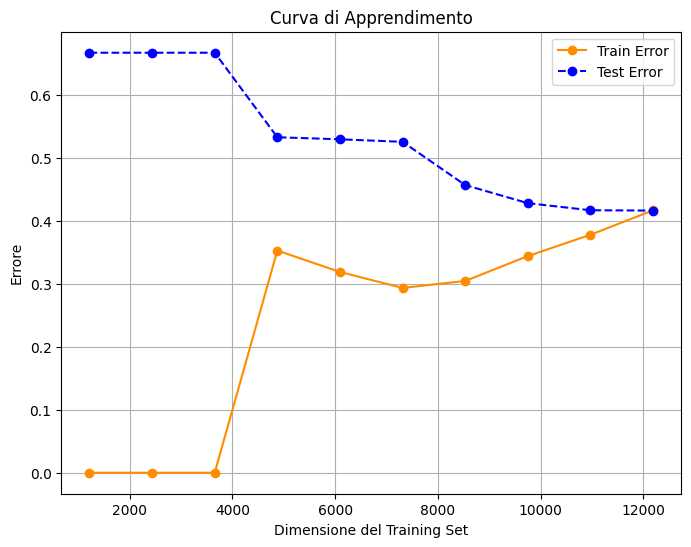

In [1]:
import pandas as pd
import os
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    """ Plotta la curva di apprendimento mostrando test error e train error. """
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', random_state=42
    )
    
    # Calcola la media e la deviazione standard dei punteggi
    train_errors = 1 - np.mean(train_scores, axis=1)
    test_errors = 1 - np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_errors, 'o-', color='darkorange', label='Train Error')
    plt.plot(train_sizes, test_errors, 'o--', color='blue', label='Test Error')
    
    plt.xlabel("Dimensione del Training Set")
    plt.ylabel("Errore")
    plt.title("Curva di Apprendimento")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


# Percorso del dataset
this_path = os.getcwd()
data_set_path = os.path.join(this_path, 'Notebooks', 'DataSet_Puglia_Augmented.csv')

# Creazione del DataFrame
df = pd.read_csv(data_set_path, dtype={"PERICOLOSITA": "int32", "LOCINC": "int32", "NUM_INCIDENTI": "float64",
 "INTNIN": "float64", "MORTI": "float64", "FERITI": "float64", "LUNGHEZZA": "float64", "MAXSPEED": "float64", "FONDOST": "int32", "ID_Segmento": "str"})

# Rimozione valori nulli
df = df.dropna()

# Separazione delle feature e della variabile target
X = df.drop(columns=['PERICOLOSITA'])
y = df['PERICOLOSITA']

# Inizializzazione del classificatore Naive Bayes
model = GaussianNB()

# K-Fold Cross-Validation con 5 fold stratificati
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []
f1_scores = []

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Mostrare i risultati
print("Cross-validation accuracy scores:", accuracies)
print("Mean accuracy: %.2f" % (sum(accuracies) / len(accuracies)))
print("Mean precision: %.2f" % (sum(precisions) / len(precisions)))
print("Mean recall: %.2f" % (sum(recalls) / len(recalls)))
print("Mean F1-score: %.2f" % (sum(f1_scores) / len(f1_scores)))

# Calcolo della curva di apprendimento
plot_learning_curve(model, X, y, cv=cv)

### Confronto dei Risultati Finali

#### **Risultati del Classificatore Naive Bayes**  
Il classificatore **Naive Bayes** ha ottenuto i seguenti risultati:  

- **Cross-validation accuracy scores:** [0.5909, 0.5781, 0.5928, 0.5871, 0.5707]
- **Accuracy media:** 0.58
- **Precision media:** 0.72
- **Recall media:** 0.58
- **F1-score medio:** 0.58  

#### Curva di apprendimento  
- **Alto errore sul test set**, che rimane elevato nonostante l'aumento dei dati.
- **Incremento improvviso dell'errore di training** dopo circa **4000 esempi**, indicando difficoltà nella generalizzazione.
- **Ampia distanza tra errore di training e test**, segno di bassa capacità predittiva.  

La curva conferma che **Naive Bayes non è adatto a questo problema**, non riuscendo a catturare le relazioni tra le feature, a differenza dei modelli più avanzati testati.  

I risultati indicano che il modello Naive Bayes, pur essendo rapido e semplice, non riesce a raggiungere le prestazioni dei modelli avanzati. Questo è attribuibile principalmente alle sue limitazioni intrinseche, come l'ipotesi di indipendenza tra le feature.  

#### **Confronto dei Modelli**
| Modello         | Accuracy Media | Precision Media | Recall Media | F1-Score Medio | Deviazione Standard |
|-----------------|----------------|-----------------|--------------|----------------|---------------------|
| Random Forest   | 0.86           | 0.86            | 0.86         | 0.86           | 0.00                |
| XGBoost         | 0.85           | 0.85            | 0.85         | 0.85           | 0.01                |
| LightGBM        | 0.86           | 0.86            | 0.86         | 0.86           | 0.01                |
| CatBoost        | 0.85           | 0.85            | 0.85         | 0.85           | 0.01                |
| Naive Bayes     | 0.58           | 0.72            | 0.58         | 0.58           | 0.01                |

# **Conclusioni**
1. **Performance Complessiva:**
   - I modelli avanzati (Random Forest, XGBoost, LightGBM e CatBoost) si sono dimostrati significativamente più efficaci rispetto a Naive Bayes, ottenendo accuratezze medie superiori all'85%.
   - Naive Bayes ha ottenuto una performance inferiore, con un'accuracy media del 58% e un F1-score equivalente.

2. **Scenari Applicativi:**
   - I modelli avanzati sono consigliati per applicazioni in cui la precisione è fondamentale, grazie alla loro capacità di catturare relazioni complesse tra le feature.
   - Naive Bayes potrebbe essere utilizzato in scenari dove la velocità e la semplicità sono prioritari rispetto alla precisione, ad esempio come baseline o per analisi esplorative.

3. **Limiti e Vantaggi:**
   - **Random Forest e XGBoost** hanno mostrato maggiore robustezza e stabilità, con deviazioni standard trascurabili.
   - **LightGBM e CatBoost** hanno prestazioni comparabili, con leggeri miglioramenti nella gestione degli errori tra le classi adiacenti.
   - **Naive Bayes** soffre di ipotesi semplificative che riducono le sue capacità predittive, specialmente in problemi multi-classe complessi come quello affrontato.

#### **Considerazioni Finali:**  
   - Il modello Naive Bayes si è rivelato **meno efficace** rispetto agli altri classificatori testati. Nonostante la sua semplicità e velocità di esecuzione, **non riesce a catturare le relazioni tra le variabili**, portando a prestazioni significativamente inferiori. 
   - Per scenari complessi, i modelli di ensemble come Random Forest e gradient boosting rappresentano la scelta ideale.
   - Tuttavia, l'ottimizzazione e l'incremento della generalizzabilità rimangono aree chiave per futuri miglioramenti, specialmente tramite tecniche come hyperparameter tuning e ulteriori augmentazioni dei dati.

Questo studio ha dimostrato l'importanza di scegliere il modello più adatto in base alle caratteristiche del problema e ai requisiti applicativi.